In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('./results/auto_data1/calibration_dof_to_step.csv', sep=',',decimal='.')
df.head()

,img_num,target_aruco,img_name,carriage_x_dist,carriage_y_dist,carriage_x_undist,carriage_y_undist,carriage_x_dist_warp,carriage_y_dist_warp,carriage_x_undist_warp,...,angle_undist,angle_dist_warp,angle_undist_warp,point_x,point_y,incr_x,incr_y,steps1,steps2,angle
0,0,17,img_0,1379.5,2236.5,1396.0,2211.0,1260.7062,1823.6497,1270.2755,...,73.073723,72.321121,72.494843,0.25,0.333333,0.25,0.333333,-213,1998,155.6862
1,1,21,img_1,2517.0,2234.0,2523.0,2205.0,2404.3930,1811.7423,2401.4902,...,-99.496105,-99.960548,-99.953033,0.50,0.333333,0.25,0.000000,-1105,1105,352.4506
2,2,20,img_2,3650.5,2239.0,3642.5,2211.0,3534.5100,1807.4935,3519.4976,...,24.035767,23.642834,23.688282,0.75,0.333333,0.25,0.000000,-1105,1105,113.7214
3,3,18,img_3,1374.0,1320.0,1390.5,1305.0,1246.2526,895.0847,1255.4397,...,NaN,NaN,NaN,0.25,0.666667,-0.50,0.333333,3104,-1319,174.7001
4,4,15,img_4,2510.5,1312.5,2517.5,1299.5,2390.4072,882.0541,2388.2563,...,-122.599206,-122.718506,-122.930870,0.50,0.666667,0.25,0.000000,-1105,1105,328.2257


# Analytic calibration

In [4]:
from pool.calibration import CameraCalibration
calib=CameraCalibration()
l_carriage_pred=[]
a=8.906e-01  
b=3.539e+00  
d=1.160e+00  
h=8.054e+00  

for index, row in df.iterrows():

    target=row[['target_x_undist','target_y_undist']].values
    angle=row[['angle']].values[0]-90
    carriage_pred = calib.predict_carriage_position_in_image_plane(target, angle, (a,b,d,h))
    l_carriage_pred.append(carriage_pred)

y_true=df[['carriage_x_undist','carriage_y_undist']].values
y_pred=np.array(l_carriage_pred)

In [5]:
from sklearn.metrics import r2_score, mean_squared_error
print(mean_squared_error(y_true,y_pred,squared=False),r2_score(y_true,y_pred))

5.952580219574759 0.9998929482455149


Text(0.5, 1.0, 'true vs predicted')

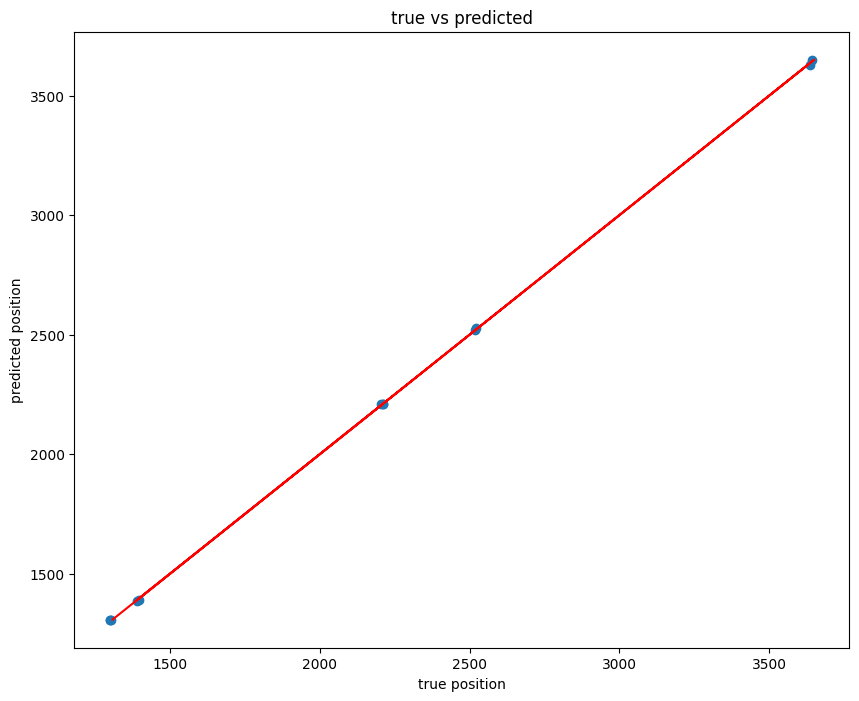

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(y_true,y_pred)
plt.plot(y_pred, y_pred, color = 'red')
plt.xlabel('true position')
plt.ylabel('predicted position')
plt.title('true vs predicted')

In [10]:
df_error=pd.DataFrame({'pred_x':y_pred[:,0],
                       'pred_y':y_pred[:,1],
                       'real_x':y_true[:,0],
                       'real_y':y_true[:,1],
                       'target_aruco': df['target_aruco'],
                       'angle': df['angle_undist']})
df_error['error_x']=y_pred[:,0]-y_true[:,0]
df_error['error_y']=y_pred[:,1]-y_true[:,1]
df_error['error']=np.sqrt(df_error['error_x'].values**2+df_error['error_y'].values**2)

In [11]:
mean_error=np.mean(df_error['error'])
std_error=np.std(df_error['error'])
rmse=np.sqrt(np.sum(df_error['error']**2)/df_error['error'].shape[0])
print(mean_error, rmse, std_error)

7.980973200530232 8.418227369902194 2.67780111729543


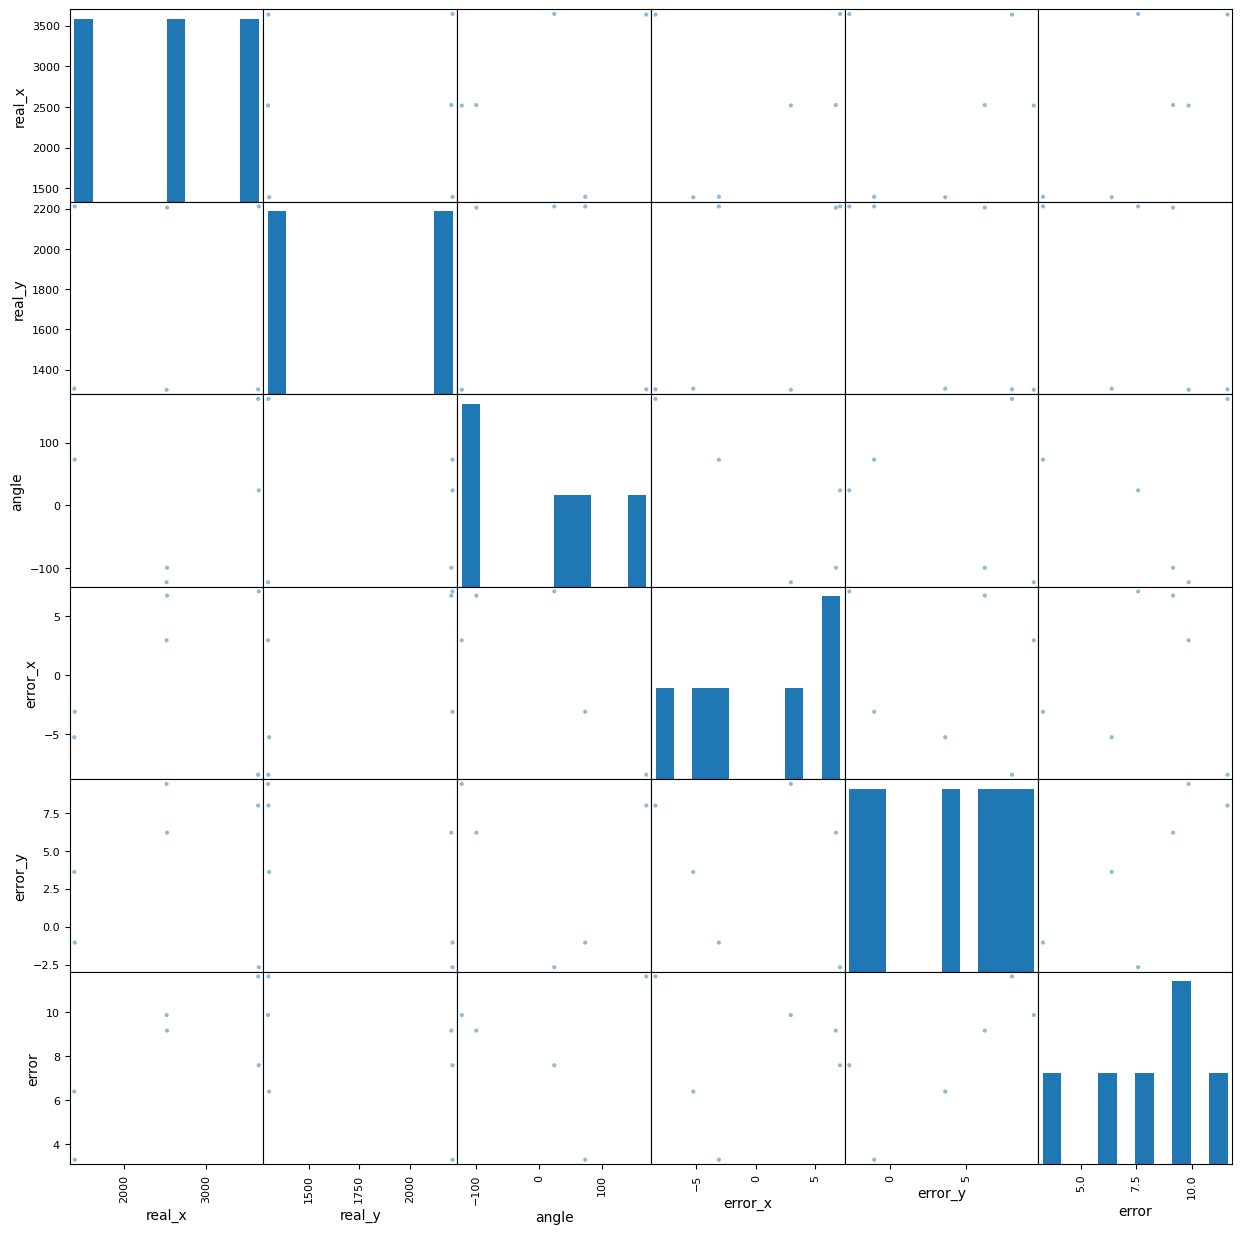

In [14]:
matrix_plot=pd.plotting.scatter_matrix(df_error[['real_x', 'real_y', 'angle','error_x', 'error_y', 'error']],figsize=(15,15))

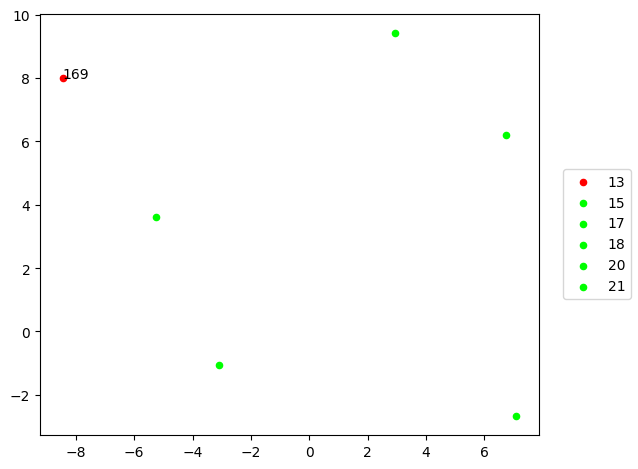

In [16]:
x_axis=df_error['error_x']
y_axis=df_error['error_y']
group = df_error['target_aruco']
d_colors = {8:'lime', 9:'lime', 10:'lime', 11:'lime', 12:'lime', 13:'lime', 14:'lime', 15:'lime', 16:'lime', 17:'lime', 18:'lime', 19:'lime', 20:'lime', 21:'lime', 23:'lime'}
aruco_to_observe=13

d_colors[aruco_to_observe]='red'
fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(df_error['error_x'][df_error['target_aruco']==g], df_error['error_y'][df_error['target_aruco']==g], c = d_colors[g], label = g, s = 20)
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.85)
for i, txt in enumerate(df_error['angle'][df_error['target_aruco']==aruco_to_observe]):
    ax.annotate(int(txt), (df_error['error_x'][df_error['target_aruco']==aruco_to_observe].iloc[i], df_error['error_y'][df_error['target_aruco']==aruco_to_observe].iloc[i]))
plt.show()